##  Gerekli Kütüphanelerin İçe Aktarılması

Bu hücrede proje boyunca kullanacağımız temel kütüphaneler içe aktarılıyor.  
- `pandas` ve `numpy`: Veri işleme için  
- `matplotlib` ve `seaborn`: Görselleştirme için  
- `sklearn`: Makine öğrenmesi algoritmaları, veri bölme, metrikler vs.  
- `re`, `string`: Metin temizleme işlemleri için  
- `warnings`: Uyarıları bastırmak için


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")


## Veri Setinin Yüklenmesi ve İlk İnceleme

CSV formatındaki veri Kaggle'dan yükleniyor.  
- Sadece `text` ve `label` sütunları kullanılıyor.  
- Eksik veriler (`NaN`) temizleniyor.  
- Etiketler sayısal hale getiriliyor.


In [2]:
df = pd.read_csv('/kaggle/input/fake-news-detection-dataset/fake_news_dataset.csv')
df = df[['text', 'label']]
df.dropna(inplace=True)
df = df[df['label'].isin(['real', 'fake'])]  # Sadece real/fake olanlar
df['label'] = df['label'].map({'real': 1, 'fake': 0})  # Real = 1, Fake = 0
df.reset_index(drop=True, inplace=True)
df.head()


,text,label
0,more tax development both store agreement lawy...,1
1,probably guess western behind likely next inve...,0
2,them identify forward present success risk sev...,0
3,phone which item yard Republican safe where po...,0
4,wonder myself fact difficult course forget exa...,0


## Etiket Dağılımı Görselleştirmesi

Veri setinde `real` ve `fake` haberlerin sayısal dağılımını gösteriyoruz.  
Dengesiz veri olup olmadığını gözlemlemek için kullanılır.


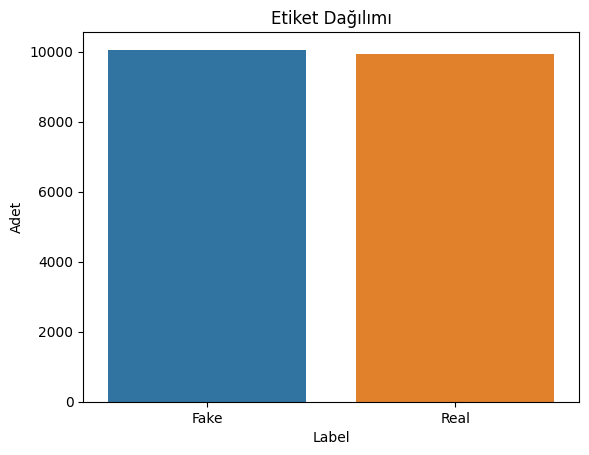

In [3]:
sns.countplot(data=df, x='label')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title('Etiket Dağılımı')
plt.xlabel('Label')
plt.ylabel('Adet')
plt.show()


## Metin Temizleme Fonksiyonu

Metinleri daha analiz edilebilir hale getirmek için:
- Küçük harfe çeviriyoruz   
- Sayılar, noktalama işaretleri gibi gereksiz karakterleri siliyoruz


In [4]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['clean_text'] = df['text'].apply(clean_text)
df[['clean_text', 'label']].head()


,clean_text,label
0,more tax development both store agreement lawy...,1
1,probably guess western behind likely next inve...,0
2,them identify forward present success risk sev...,0
3,phone which item yard republican safe where po...,0
4,wonder myself fact difficult course forget exa...,0


##  Metin Uzunluğu Analizi

Her haberin kelime sayısını hesaplayarak dağılımını analiz ediyoruz.  
Bu, sahte haberler ile gerçek haberlerin uzunluk açısından farklarını görmeyi sağlar.


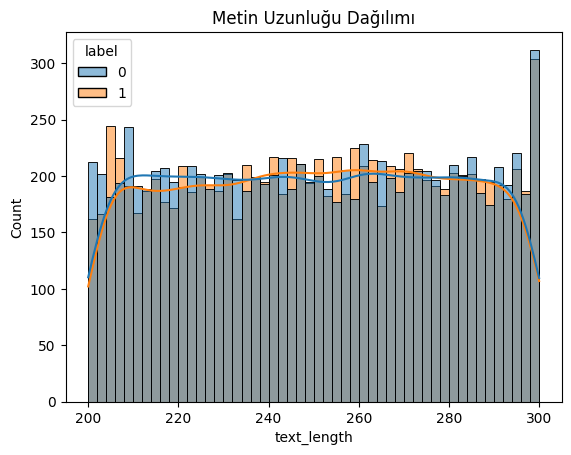

In [5]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Metin Uzunluğu Dağılımı')
plt.show()


## TF-IDF ile Özellik Çıkartma

Metinleri sayısal verilere dönüştürmek için TF-IDF kullanıyoruz.  
Her kelimenin belgedeki göreceli önemini belirleyerek 3000 özellik çıkarılıyor.


In [6]:
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['clean_text']).toarray()
y = df['label'].values


## Eğitim ve Test Verisine Ayırma

Veri seti %80 eğitim, %20 test olarak ayrılıyor.  
`stratify=y` ile sınıf oranları korunuyor.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Eğitim verisi boyutu: {X_train.shape}")
print(f"Test verisi boyutu: {X_test.shape}")


Eğitim verisi boyutu: (16000, 969)
Test verisi boyutu: (4000, 969)


## Lojistik Regresyon Modelinin Eğitilmesi

Gözetimli öğrenme algoritmalarından Lojistik Regresyon kullanılarak model eğitiliyor.  
Model test verisi üzerinde tahmin yapıyor.


In [8]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Lojistik Regresyon Doğruluk:", accuracy_score(y_test, y_pred_lr))


Lojistik Regresyon Doğruluk: 0.50825


## 5-Fold Çapraz Doğrulama

Modelin farklı veri alt kümelerinde tutarlı performans gösterip göstermediğini kontrol etmek için çapraz doğrulama uygulanıyor.


In [9]:
cv_scores = cross_val_score(lr, X_train, y_train, cv=5)
print("Çapraz Doğrulama Doğruluk Ortalaması:", cv_scores.mean())


Çapraz Doğrulama Doğruluk Ortalaması: 0.5126875


## Hiperparametre Ayarlaması (GridSearchCV)

Modelin başarımını artırmak için `C` hiperparametresi test edilerek en iyi değer belirleniyor.


In [10]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("En iyi parametreler:", grid.best_params_)


En iyi parametreler: {'C': 0.01}


## Nihai Modelin Değerlendirilmesi

En iyi model ile test verisi üzerinde tahmin yapılır.  
Doğruluk, precision, recall, F1 gibi metrikler hesaplanır.  
Karışıklık matrisi ile doğru/yanlış sınıflamalar görselleştirilir.


Doğruluk: 0.4995
Precision: 0.4934804413239719
Recall: 0.2473604826546003
F1 Score: 0.3295378432685867


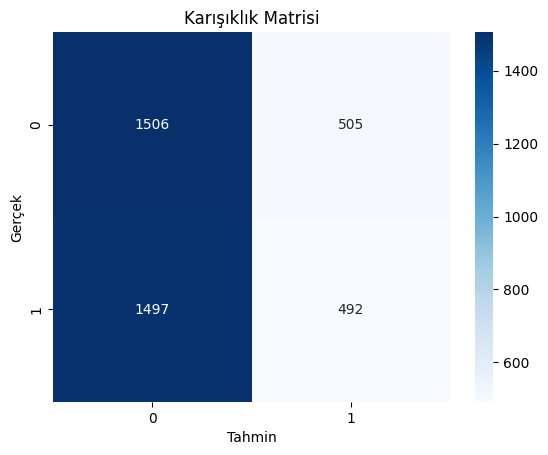

In [11]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Doğruluk:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Karışıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()
